# Import

In [1]:
import os
import torch
import pytorch_lightning as pl
from time import time_ns
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from rnaquanet.network.graph_regression_network import GraphRegressionNetwork
from rnaquanet.network.grn_data_module import GRNDataModule
from rnaquanet.utils.rnaquanet_config import RnaquanetConfig
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from torch.optim import Adam
from torch.nn import (
    BatchNorm1d,
    Identity,
    ReLU,
    LeakyReLU,
    Linear,
    MSELoss,
    SmoothL1Loss,
    HuberLoss
)
import torch.nn.functional as F
from torch_geometric.nn import (
    GATConv,
    GCNConv,
    Sequential,
    global_mean_pool,
    BatchNorm,
    TransformerConv,
    GATv2Conv
)
from torch_geometric.nn.models import (
    GAT
)
from torch_geometric.loader import DataLoader
import numpy as np
from rnaquanet.data.preprocessing.hdf5_utils import load_data_from_hdf5
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from rnaquanet.network.h5_graph_dataset import H5GraphDataset
import math

In [2]:
seg1_train_data = H5GraphDataset('/app/data/segments_1_coords/train.h5', max_iterations=80000).__enter__()
seg1_val_data = H5GraphDataset('/app/data/segments_1_coords/val.h5').__enter__()

seg2_train_data = H5GraphDataset('/app/data/segments_2_coords/train.h5', max_iterations=80000).__enter__()
seg2_val_data = H5GraphDataset('/app/data/segments_2_coords/val.h5').__enter__()

seg3_train_data = H5GraphDataset('/app/data/segments_3_coords/train.h5', max_iterations=80000).__enter__()
seg3_val_data = H5GraphDataset('/app/data/segments_3_coords/val.h5').__enter__()

ares_train_data = H5GraphDataset('/app/data/ares/train.h5').__enter__()
ares_val_data = H5GraphDataset('/app/data/ares/val.h5').__enter__()
ares_test_data = H5GraphDataset('/app/data/ares/test.h5').__enter__()

In [3]:
def plot_loss_chart(losses, epoch):
    bars = len(losses.values()) # num of bars
    epochs = range(1, epoch+2)
    width = 1.0/bars * 0.75
    multiplier = 0
    _, ax = plt.subplots(layout='constrained')

    for key, value in losses.items():
        x = np.arange(len(value['losses']))

        loss_values = value['losses']
        offset = width * multiplier
        rects = ax.bar(x + offset, loss_values, width, label=key, color=value['color'], alpha=0.5)
        ax.bar_label(rects, fmt='%0.0f', padding=3)
        multiplier += 1

    x = np.arange(len(epochs))
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_xticks(x + ((bars-1)/2)*width, epochs)
    ax.legend()
    plt.show()

def get_desc(epoch, losses):
    desc = f'Epoch {epoch+1}\n'
    for key, value in losses.items():
        if value['losses']:
            desc += f'Prev {key} {value["losses"][-1]:.2f}\tBest {key} {np.min(value["losses"]):.2f}\n'
    return desc.rstrip('\n')

def process_epoch(
        epoch, 
        batch_size, 
        device, 
        model,
        loss_fn,
        mse_no_reduce,
        optimizer,
        patience, 
        
        losses, key,
        best_model, best_loss
    ):
    step = []

    if losses[key]['data'].max_iterations != None:
        losses[key]['data'].shuffle()
    

    with tqdm(total=len(losses[key]['data']), desc=f'{key.capitalize()} epoch {epoch+1}', position=0, leave=True) as progressbar:
        if not losses[key]['train']:
            with torch.no_grad():
                for item in DataLoader(losses[key]['data'], batch_size=batch_size, shuffle=False, num_workers=4):
                    item = item.to(device)
                    y_pred = model(x=item.x, edge_index=item.edge_index, edge_attr=item.edge_attr, batch=item.batch).view(-1)
                    step.extend(mse_no_reduce(y_pred, item.y).cpu().tolist())
                    progressbar.update(item.y.cpu().shape[0])
        else:
            for item in DataLoader(losses[key]['data'], batch_size=batch_size, shuffle=False, num_workers=4):
                item = item.to(device)
                y_pred = model(x=item.x, edge_index=item.edge_index, edge_attr=item.edge_attr, batch=item.batch).view(-1)
                loss = loss_fn(y_pred, item.y)
                step.extend(mse_no_reduce(y_pred, item.y).cpu().tolist())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                progressbar.update(item.y.cpu().shape[0])
        
    losses[key]['losses'].append(np.mean(step))
    clear_output(wait=True)
    print(get_desc(epoch, losses))
    plot_loss_chart(losses, epoch)

    index = np.argmin(losses[key]['losses'])
    if losses[key]['patience']:
        if index == (len(losses[key]['losses']) - 1):
            return model.state_dict(), losses[key]['losses'][index], False
    return best_model, best_loss, losses[key]['patience'] and index <= (epoch-patience)

Epoch 6
Prev seg3 train 28.97	Best seg3 train 28.97
Prev seg3 val 39.40	Best seg3 val 38.67
Prev seg2 val 42.08	Best seg2 val 37.90
Prev seg1 val 51.96	Best seg1 val 47.31
Prev ares train 26.80	Best ares train 22.27
Prev ares val 34.35	Best ares val 29.46
Prev ares test 27.01	Best ares test 23.02


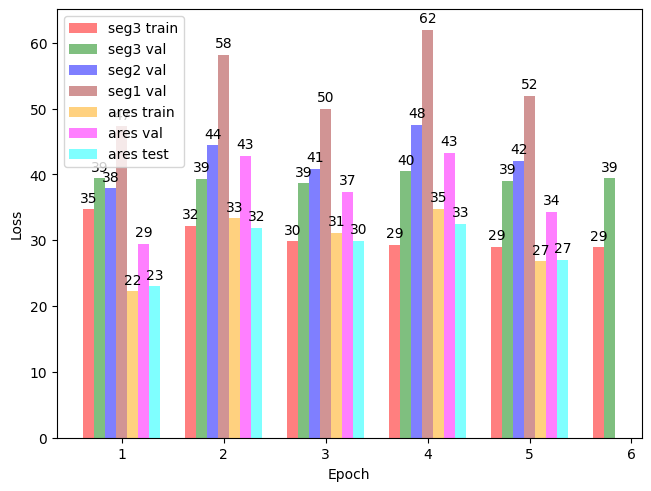

In [4]:
torch.set_float32_matmul_precision('high')
torch.manual_seed(2137)
device = torch.device('cuda:0')

max_epochs = 1000
batch_size = 32
patience = 3

model = Sequential('x, edge_index, edge_attr, batch', [
    (TransformerConv(in_channels=99, out_channels=512, heads=4, dropout=0.5), 'x, edge_index -> x'),
    (BatchNorm(in_channels=512*4), 'x -> x'),
    (ReLU(), 'x -> x'),
    (TransformerConv(in_channels=512*4, out_channels=256, heads=4), 'x, edge_index -> x'),
    (BatchNorm(in_channels=128*8), 'x -> x'),
    (ReLU(), 'x -> x'),
    (TransformerConv(in_channels=128*8, out_channels=256, heads=8), 'x, edge_index -> x'),
    (BatchNorm(in_channels=256*8), 'x -> x'),
    (ReLU(), 'x -> x'),
    (TransformerConv(in_channels=256*8, out_channels=128, heads=8), 'x, edge_index -> x'),
    (BatchNorm(in_channels=128*8), 'x -> x'),
    (ReLU(), 'x -> x'),

    (GCNConv(in_channels=128*8, out_channels=512), 'x, edge_index -> x'),
    (global_mean_pool, 'x, batch -> x'),

    (Linear(in_features=512, out_features=64), 'x -> x'),
    (ReLU(), 'x -> x'),
    (Linear(in_features=64, out_features=1), 'x -> x'),
]).to(device)

loss_fn = MSELoss(reduction='mean').to(device)
mse_no_reduce = MSELoss(reduction='none').to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

losses = {
    'seg3 train': {
        'data': seg3_train_data,
        'losses': [],
        'color': 'red',
        'train': True,
        'patience': False
    },
    'seg3 val': {
        'data': seg3_val_data,
        'losses': [],
        'color': 'green',
        'train': False,
        'patience': True
    },
    'seg2 val': {
        'data': seg2_val_data,
        'losses': [],
        'color': 'blue',
        'train': False,
        'patience': False
    },
    'seg1 val': {
        'data': seg1_val_data,
        'losses': [],
        'color': 'brown',
        'train': False,
        'patience': False
    },
    'ares train': {
        'data': ares_train_data,
        'losses': [],
        'color': 'orange',
        'train': False,
        'patience': False
    },
    'ares val': {
        'data': ares_val_data,
        'losses': [],
        'color': 'magenta',
        'train': False,
        'patience': False
    },
    'ares test': {
        'data': ares_test_data,
        'losses': [],
        'color': 'cyan',
        'train': False,
        'patience': False
    },
}

best_model = None
best_loss = float('inf')

for epoch in range(max_epochs):
    for key in losses.keys():
        best_model, best_loss, cond = process_epoch(epoch, batch_size, device, model, loss_fn, mse_no_reduce, optimizer, patience, losses, key, best_model, best_loss)
        if cond:
            break
    else:
        continue
    break

In [5]:
model.load_state_dict(best_model)

with torch.no_grad():
    n = 0
    print(f'predicted\tground truth\tdiff')
    for item in DataLoader(losses['seg1 val']['data'], batch_size=1, shuffle=True, num_workers=4):
        item = item.to(device)
        y_pred = model(x=item.x, edge_index=item.edge_index, edge_attr=item.edge_attr, batch=item.batch).view(-1)
        print(f'{y_pred.cpu().item()}\t{item.y.cpu().item()}\t{y_pred.cpu().item()-item.y.cpu().item()}')
        n += 1
        if n == 20:
            break
    n = 0
    print(f'predicted\tground truth\tdiff')
    for item in DataLoader(losses['ares test']['data'], batch_size=1, shuffle=True, num_workers=4):
        item = item.to(device)
        y_pred = model(x=item.x, edge_index=item.edge_index, edge_attr=item.edge_attr, batch=item.batch).view(-1)
        print(f'{y_pred.cpu().item()}\t{item.y.cpu().item()}\t{y_pred.cpu().item()-item.y.cpu().item()}')
        n += 1
        if n == 20:
            break

predicted	ground truth	diff
12.197774887084961	1.656000018119812	10.541774868965149
12.344002723693848	1.9900000095367432	10.354002714157104
13.08269214630127	3.2760000228881836	9.806692123413086
14.131386756896973	2.4609999656677246	11.670386791229248
12.890257835388184	1.0989999771118164	11.791257858276367
12.51089859008789	5.570000171661377	6.940898418426514
11.589924812316895	4.296999931335449	7.292924880981445
12.240706443786621	11.970999717712402	0.26970672607421875
12.754363059997559	0.5339999794960022	12.220363080501556
8.047204971313477	2.446000099182129	5.601204872131348
14.346866607666016	2.947000026702881	11.399866580963135
8.636512756347656	1.4809999465942383	7.155512809753418
12.766552925109863	7.254000186920166	5.512552738189697
10.504449844360352	3.2279999256134033	7.276449918746948
12.582425117492676	2.066999912261963	10.515425205230713
11.945897102355957	0.5440000295639038	11.401897072792053
12.805501937866211	3.7019999027252197	9.103502035140991
11.940389633178711	5.